In [ ]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os

# Configurar Dask
dask.config.set({"dataframe.convert-string": False})
client = Client()

# Paths locales
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

2025-11-15 16:42:04,653 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37827'.
2025-11-15 16:42:04,661 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41609'.
2025-11-15 16:42:04,703 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35461'.
2025-11-15 16:42:04,706 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36697'.


In [2]:
# Cargar datos con Dask (solo 10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
# Usar 10% de los archivos
num_files_train = max(1, int(len(parquet_files_train) * 0.5))
parquet_files_train = parquet_files_train[:num_files_train]

train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')
print(f"Train cargado con {num_files_train} archivos (10% del total)")

parquet_files_test = glob(os.path.join(test_path, '**/part-*.parquet'), recursive=True)
num_files_test = max(1, int(len(parquet_files_test) * 0.5))
parquet_files_test = parquet_files_test[:num_files_test]

test_ddf = dd.read_parquet(parquet_files_test, engine='pyarrow')
print(f"Test cargado con {num_files_test} archivos (10% del total)")

Train cargado con 72 archivos (10% del total)
Test cargado con 48 archivos (10% del total)


In [3]:
# Exploración básica
train_sample = train_ddf.head(10)
test_sample = test_ddf.head(10)
print(f"Train columns: {train_ddf.columns.tolist()}")
print(f"Test columns: {test_ddf.columns.tolist()}")
display(train_sample.head())
display(test_sample.head())

Train columns: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'release_date', 'release_msrp', 'weekday', 'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'city_hist', 'country_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'dev_language_hist', 'dev_osv_hist', 'first_request_ts', 'first_request_ts_bundle', 'first_request_ts_category_bottom_taxonomy', 'hour_ratio', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'iap_revenue_usd_category_bottom_taxonomy', 'last_

,buyer_d1,buyer_d7,buyer_d14,buyer_d28,buy_d7,buy_d14,buy_d28,iap_revenue_d7,iap_revenue_d14,iap_revenue_d28,...,user_bundles_l28d,weekend_ratio,weeks_since_first_seen,wifi_ratio,whale_users_bundle_num_buys_prank,whale_users_bundle_revenue_prank,whale_users_bundle_total_num_buys,whale_users_bundle_total_revenue,row_id,datetime
0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,None,NaN,NaN,NaN,None,None,None,None,4864be1c-903a-4c40-9d8d-b8fa1d3fa80b,2025-10-01-01-00
1,0,0,0,0,0,0,0,0.0,0.0,0.0,...,None,NaN,NaN,NaN,None,None,None,None,f31fb554-a61e-402e-a502-bc354e8ea45a,2025-10-01-01-00
2,0,0,0,0,0,0,0,0.0,0.0,0.0,...,"[5854742bcf87cfbd1283b6b2ac55f361d8f00c9f, be4...",0.447773,6.0,0.923835,"[(c39b147d59d698641d4198d04ee2e3e0f78b1122, 0.0)]","[(c39b147d59d698641d4198d04ee2e3e0f78b1122, 0....","[(c39b147d59d698641d4198d04ee2e3e0f78b1122, 1)]","[(c39b147d59d698641d4198d04ee2e3e0f78b1122, 3....",23792b69-085c-482c-ac9a-5a7df82095f2,2025-10-01-01-00
3,0,0,0,0,0,0,0,0.0,0.0,0.0,...,"[4f018980217d4b5ceb987d5e3e9477d176a23dcb, 547...",0.355771,6.0,0.912416,None,None,None,None,121d0d93-7b64-4fb5-99df-352d3fe72d0b,2025-10-01-01-00
4,0,0,0,0,0,0,0,0.0,0.0,0.0,...,None,NaN,0.0,NaN,None,None,None,None,4351278e-77d9-4582-bbcc-923829c39ff8,2025-10-01-01-00


,advertiser_bundle,advertiser_category,advertiser_subcategory,advertiser_bottom_taxonomy_level,carrier,country,region,dev_make,dev_model,dev_os,...,user_bundles_l28d,weekend_ratio,weeks_since_first_seen,wifi_ratio,whale_users_bundle_num_buys_prank,whale_users_bundle_revenue_prank,whale_users_bundle_total_num_buys,whale_users_bundle_total_revenue,row_id,datetime
0,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,None,eg,None,samsung,sm-f711b,android,...,None,NaN,NaN,NaN,None,None,None,None,ee9021dc-1ad8-40e8-a56e-d1718b971489,2025-10-08-01-00
1,ff9bdd5dc427114eef1c6372526548e01a5ef45d,finance,finance,investing & financial management (general),None,ar,None,apple,iphone 14,ios,...,[8369baf8e7c692239c61d312cceeefee68176311],0.2,6.0,0.0,None,None,None,None,3c907437-793b-493e-830b-8fe4aaa12876,2025-10-08-01-00
2,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,None,ar,None,samsung,sm-a705fn,android,...,None,NaN,NaN,NaN,None,None,None,None,1c49cbb9-a7d3-480d-9cf2-9f87f79108c3,2025-10-08-01-00
3,d238ae3ee12dcef245f58f4813b79021c0a9155e,games,games/simulation,tycoon / crafting,None,mx,None,apple,iphone 14 pro max,ios,...,None,NaN,NaN,NaN,None,None,None,None,12d3d28c-8168-4a20-9220-9d2b6c006c1b,2025-10-08-01-00
4,db42749ef73fd488a95e37718f033eab132da07c,application,communication,social messaging,spectrum,us,california,google,pixel 6,android,...,None,NaN,NaN,NaN,None,None,None,None,5b9ad299-f0f2-480a-96e8-f5115f346fea,2025-10-08-01-00


In [ ]:
# Preparar datos para LGBM (computar a Pandas)
train_df = train_ddf.compute(scheduler='synchronous')  # Usa menos memoria
test_df = test_ddf.compute(scheduler='synchronous')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.gc.GCDiagnosis object at 0x761f4f7a0760>>
Traceback (most recent call last):
  File "/home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/distributed/gc.py", line 198, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
2025-11-15 16:42:04,661 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-11-15 16:42:04,702 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-11-15 16:42:04,705 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-11-15 16:42:04,714 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.
2025-11-15 16:42:07,479 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2025-11-15 16:42:07,502 - distributed.nanny - ERROR - Worker process died unexpectedl

In [ ]:
# Definir labels a excluir y features
labels_to_exclude = ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28',
                     'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration',
                     'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14',
                     'retention_d1', 'retention_d3', 'retention_d7']

features = [col for col in train_df.columns if col not in labels_to_exclude + ['row_id', 'datetime']]

cat_features = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
                'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region',
                'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'weekday']

print(f"Total features: {len(features)}")
print(f"Categorical features: {len(cat_features)}")

Total features: 67
Categorical features: 12


In [ ]:
# Split time-based: train early, val late
# Ensure datetime is actual datetime (was category)
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

cutoff = train_df['datetime'].quantile(0.8)
val_mask = train_df['datetime'] >= cutoff

# Guardar row_id para la submisión
val_row_ids = train_df[val_mask]['row_id'].values

X_train = train_df[~val_mask][features]
y_train = train_df[~val_mask]['iap_revenue_d7']
X_val = train_df[val_mask][features]
y_val = train_df[val_mask]['iap_revenue_d7']

print(f"Train samples: {len(X_train)}")
print(f"Val samples: {len(X_val)}")

Train samples: 734322
Val samples: 292535


In [ ]:
# Transform target
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Crear datasets LGBM
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

print("Datasets LGBM creados")

Datasets LGBM creados


In [ ]:
# Parámetros LGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

print("Parámetros configurados")

Parámetros configurados


In [ ]:
# Convertir columnas object a numéricas (excepto categorical features)
numeric_cols = X_train.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if col not in cat_features:
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
        except:
            pass

# Rellenar NaN generados por conversión fallida
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Asegurar que cat_features estén como category
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("Tipos de datos convertidos correctamente")
print(X_train.dtypes)

Tipos de datos convertidos correctamente
retentiond7                           float64
advertiser_bundle                    category
advertiser_category                  category
advertiser_subcategory               category
advertiser_bottom_taxonomy_level     category
                                       ...   
wifi_ratio                            float64
whale_users_bundle_num_buys_prank     float64
whale_users_bundle_revenue_prank      float64
whale_users_bundle_total_num_buys     float64
whale_users_bundle_total_revenue      float64
Length: 67, dtype: object


In [ ]:
# Usar solo features que estén en los datos y sean válidas
cat_features_valid = [col for col in cat_features if col in features]

# Crear datasets LGBM
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

In [ ]:
# Entrenar modelo
model = lgb.train(
    params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("Modelo entrenado")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	training's rmse: 0.389217	valid_1's rmse: 0.385319
Modelo entrenado
Early stopping, best iteration is:
[105]	training's rmse: 0.389217	valid_1's rmse: 0.385319
Modelo entrenado


MSLE en validación: 0.1484632701856439


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

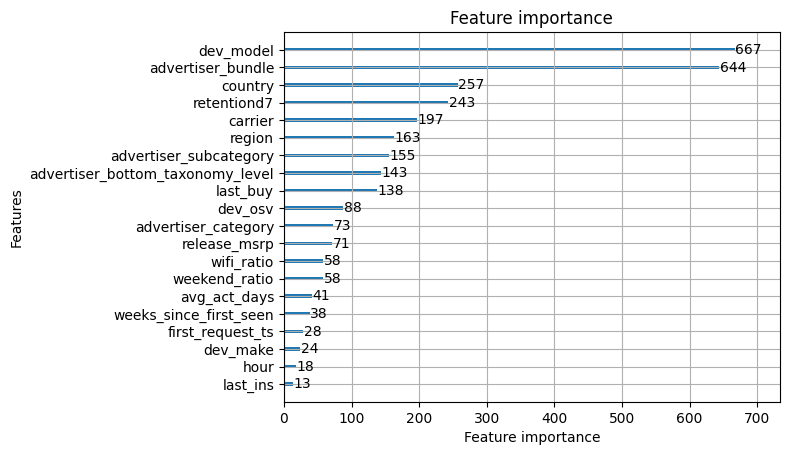

In [ ]:
# Evaluar en validación
pred_log = model.predict(X_val)
pred_val = np.expm1(pred_log).clip(0, None)
msle = mean_squared_log_error(y_val, pred_val)
print(f"MSLE en validación: {msle}")

# Feature importance
lgb.plot_importance(model, max_num_features=20)